In [36]:
import os
import geopandas as gpd
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt

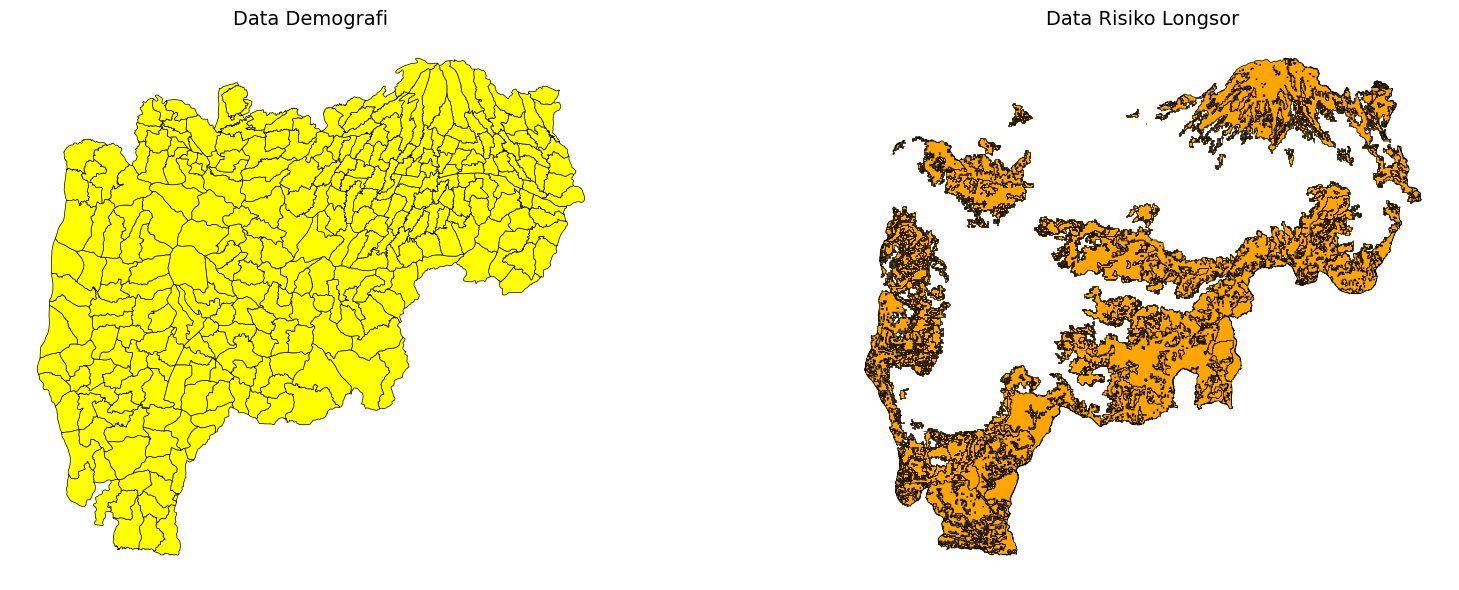

In [37]:
# Melakukan Get Data API

urls = {
    "Demografi":"https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=68ab493ab2fcc5561a2f1732&project_id=68a863e8f33d3b7c30cc8a06&limit=10000",
    "Risiko Longsor":"https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=68ab477fb2fcc5561a2ed2a1&project_id=68a863e8f33d3b7c30cc8a06&limit=10000"
}

# Menambahkan kolom Skor

def kategori_kepadatan(value: float) -> str:
    """
    Mengubah nilai kepadatan penduduk menjadi kategori teks.
    """
    if value < 1.7445907:
        return "RENDAH"
    elif value < 2.7445907:
        return "CUKUP RENDAH"
    elif value < 3.7445907:
        return "SEDANG"
    elif value < 4.7445907:
        return "CUKUP TINGGI"
    else:
        return "TINGGI"

# Membuat Definisi Get Data
def get_data(url: str, layer_name: str) -> gpd.GeoDataFrame:
    response = requests.get(url, timeout=30)

    if response.status_code != 200:
        raise RuntimeError(
            f"Failed Get Data from {url} - Status Code: {response.status_code}"
        )

    geojson_data = response.json()
    gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])
    gdf = gdf.set_geometry('geometry')
    gdf.crs = "EPSG:4326"

    # Menambahkan kolom skor berdasarkan variabel data
    if layer_name == "Demografi":
        if "KEPADATAN PENDUDUK" not in gdf.columns:
            raise KeyError(
                "Kolom 'KEPADATAN PENDUDUK tidak ditemukan pada layer Demografi'"
            )
        gdf['KEPADATAN PENDUDUK'] = pd.to_numeric(gdf['KEPADATAN PENDUDUK'], errors='coerce')
        gdf['KEPADATAN PENDUDUK'] = gdf["KEPADATAN PENDUDUK"].fillna(0)

        gdf["KELAS KEPADATAN"] = gdf["KEPADATAN PENDUDUK"].apply(kategori_kepadatan)

        column_name = "KELAS KEPADATAN"
        score_col = "SKOR_DEMOGRAFI"
        mapping = {
            "RENDAH": 1,
            "CUKUP RENDAH": 2,
            "SEDANG": 3,
            "CUKUP TINGGI": 4,
            "TINGGI": 5,
        }
    elif layer_name == "Risiko Longsor":
        column_name = "Kelas"
        score_col = "SKOR_LONGSOR"
        mapping = {
            "SANGAT RENDAH": 1,
            "CUKUP RENDAH": 2,
            "SEDANG": 3,
            "CUKUP TINGGI": 4,
            "TINGGI": 5
        }

    else:
        raise ValueError(f"Layer Not Found: {layer_name}")
    
    gdf[score_col] = (
        gdf[column_name]
        .astype(str)
        .str.upper()
        .map(mapping)
        .fillna(0)
        .astype(int)
    )
    return gdf


# Mengambil Data dari Semua Layer

gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_longsor = get_data(urls["Risiko Longsor"], "Risiko Longsor")

# Membuat visualisasi variable menggunakan Matplotlib

def visualize_data (gdfs):
    fig, axes =plt.subplots(1, len(gdfs), figsize = (18, 6))
    color_map = ['yellow', 'orange']

    for ax, (name, gdf), color in zip(axes, gdfs.items(), color_map):
        gdf.plot(ax=ax, color=color, edgecolor='black', linewidth=0.5)
        ax.set_title(name, fontsize=14)
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

# Menampilkan visual dari ketiga variable / GeoDataFrame

visualize_data({
    "Data Demografi": gdf_demografi,
    "Data Risiko Longsor": gdf_longsor
})

In [38]:
# 1. Cek kolom-kolom yang ada di GeoDataFrame
print("Kolom-kolom pada gdf_demografi:")
print(gdf_demografi.columns)

# 2. Lihat beberapa baris awal untuk memastikan isi data
print("\nData 5 baris awal:")
print(gdf_demografi.head())

# 3. Cek tipe data dari kolom 'KEPADATAN PENDUDUK'
if 'KEPADATAN PENDUDUK' in gdf_demografi.columns:
    print("\nTipe data kolom 'KEPADATAN PENDUDUK':")
    print(gdf_demografi['KEPADATAN PENDUDUK'].dtype)
    
    # 4. Cek apakah ada nilai null atau bukan angka
    print("\nJumlah nilai null di kolom 'KEPADATAN PENDUDUK':")
    print(gdf_demografi['KEPADATAN PENDUDUK'].isnull().sum())
    
    print("\nData unik dan contoh nilai di kolom 'KEPADATAN PENDUDUK':")
    print(gdf_demografi['KEPADATAN PENDUDUK'].unique()[:10])
else:
    print("Kolom 'KEPADATAN PENDUDUK' tidak ditemukan di gdf_demografi.")


Kolom-kolom pada gdf_demografi:
Index(['geometry', 'fid', 'ID_PROV', 'PROVINSI', 'ID_KABKOT', 'KABKOT',
       'ID_KEC', 'KECAMATAN', 'ID_DESA', 'DESA',
       ...
       'PERDAGANGAN', 'PERAWAT', 'NELAYAN', 'PELAJAR DAN MAHASISWA', 'GURU',
       'WIRASWASTA', 'PENGACARA', 'PEKERJAAN LAINNYA', 'KELAS KEPADATAN',
       'SKOR_DEMOGRAFI'],
      dtype='object', length=105)

Data 5 baris awal:
                                            geometry   fid ID_PROV  \
0  MULTIPOLYGON Z (((110.83339 -8.08119 0, 110.83...  8408      33   
1  MULTIPOLYGON Z (((110.86258 -8.06235 0, 110.86...  8407      33   
2  MULTIPOLYGON Z (((110.83242 -8.06008 0, 110.83...  8406      33   
3  MULTIPOLYGON Z (((110.8238 -8.05317 0, 110.823...  8405      33   
4  MULTIPOLYGON Z (((111.01547 -8.03844 0, 111.01...  8404      33   

      PROVINSI ID_KABKOT    KABKOT    ID_KEC     KECAMATAN        ID_DESA  \
0  JAWA TENGAH     33.12  WONOGIRI  33.12.01  PRACIMANTORO  33.12.01.2007   
1  JAWA TENGAH     33.12  WONO

In [39]:
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely

def kategori_kepadatan(value: float) -> str:
    """
    Mengubah nilai kepadatan penduduk menjadi kategori teks.
    """
    if value < 1.7445907:
        return "RENDAH"
    elif value < 2.7445907:
        return "CUKUP RENDAH"
    elif value < 3.7445907:
        return "SEDANG"
    elif value < 4.7445907:
        return "CUKUP TINGGI"
    else:
        return "TINGGI"

# Membuat Definisi Get Data
def get_data(url: str, layer_name: str) -> gpd.GeoDataFrame:
    response = requests.get(url, timeout=30)

    if response.status_code != 200:
        raise RuntimeError(
            f"Failed Get Data from {url} - Status Code: {response.status_code}"
        )

    geojson_data = response.json()
    gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])
    gdf = gdf.set_geometry('geometry')
    gdf.crs = "EPSG:4326"

    # Menambahkan kolom skor berdasarkan variabel data
    if layer_name == "Demografi":
        if "KEPADATAN PENDUDUK" not in gdf.columns:
            raise KeyError(
                "Kolom 'KEPADATAN PENDUDUK tidak ditemukan pada layer Demografi'"
            )
        gdf['KEPADATAN PENDUDUK'] = pd.to_numeric(gdf['KEPADATAN PENDUDUK'], errors='coerce')
        gdf['KEPADATAN PENDUDUK'] = gdf["KEPADATAN PENDUDUK"].fillna(0)
        print(gdf['KEPADATAN PENDUDUK'].describe())

        gdf["KELAS KEPADATAN"] = gdf["KEPADATAN PENDUDUK"].apply(kategori_kepadatan)
        print(gdf['KELAS KEPADATAN'].value_counts())

        column_name = "KELAS KEPADATAN"
        score_col = "SKOR_DEMOGRAFI"
        mapping = {
            "RENDAH": 1,
            "CUKUP RENDAH": 2,
            "SEDANG": 3,
            "CUKUP TINGGI": 4,
            "TINGGI": 5,
        }
    elif layer_name == "Risiko Longsor":
        column_name = "Kelas"
        score_col = "SKOR_LONGSOR"
        mapping = {
            "SANGAT RENDAH": 1,
            "CUKUP RENDAH": 2,
            "SEDANG": 3,
            "CUKUP TINGGI": 4,
            "TINGGI": 5
        }

    else:
        raise ValueError(f"Layer Not Found: {layer_name}")
    
    gdf[score_col] = (
        gdf[column_name]
        .astype(str)
        .str.upper()
        .map(mapping)
        .fillna(0)
        .astype(int)
    )
    print(f"Berhasil Menambahkan kolom skor '{score_col}' untuk layer {layer_name}")
   
    return gdf

urls = {
    "Demografi":"https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=68ab493ab2fcc5561a2f1732&project_id=68a863e8f33d3b7c30cc8a06&limit=10000",
    "Risiko Longsor":"https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=68ab477fb2fcc5561a2ed2a1&project_id=68a863e8f33d3b7c30cc8a06&limit=10000"
}

# Mengatasi Nilai Null

gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_longsor = get_data(urls["Risiko Longsor"], "Risiko Longsor")

for gdf, score_col in [(gdf_demografi, "SKOR_DEMOGRAFI"),
                 (gdf_longsor, "SKOR_LONGSOR")]:
    if score_col not in gdf.columns:
        gdf[score_col] = 0
    else:
        gdf[score_col] = gdf[score_col].fillna(0)

# Analisis Intersect (Overlay)
intersection_gdf = gdf_demografi.copy()

if not gdf_longsor.empty:
    intersection_gdf = gpd.overlay(
        intersection_gdf,
        gdf_longsor,
        how="intersection",
        keep_geom_type=False
    )

# Fix Geometry
if "geometry" not in intersection_gdf.columns:
    raise RuntimeError("Hasil Overlay tidak memiliki kolom geometry")

intersection_gdf = intersection_gdf.set_geometry("geometry")

valid_mask = intersection_gdf.is_valid
if not valid_mask.all():
    def _make_valid(geom):
        try:
            return shapely.make_valid(geom)
        except AttributeError:
            return geom.buffer(0)

    intersection_gdf.loc[~valid_mask, "geometry"] = (
        intersection_gdf.loc[~valid_mask, "geometry"].apply(_make_valid)
    )
intersection_gdf = intersection_gdf[intersection_gdf.is_valid]


# Mengatasi nilai null pasca fix geometry
for col in ['SKOR_DEMOGRAFI', 'SKOR_LONGSOR']:
    if col not in intersection_gdf.columns:
        intersection_gdf[col] = 0
    else:
        intersection_gdf[col]  = intersection_gdf[col].fillna(0)

#Penjumlahan kolom skor di masing-masing variable
intersection_gdf["SKOR_TOTAL"] = (
    intersection_gdf["SKOR_DEMOGRAFI"] + intersection_gdf['SKOR_LONGSOR']
)

#Klasifikasi
intersection_gdf["KESESUAIAN"] = pd.cut(
    intersection_gdf["SKOR_TOTAL"],
    bins=[-0.1,2,4,6,8,10],
    labels=["RENDAH", "CUKUP RENDAH", "SEDANG", "CUKUP TINGGI", "TINGGI"],
    include_lowest=True
)

cols_to_show = ["SKOR_DEMOGRAFI", "SKOR_LONGSOR", "SKOR_TOTAL", "KESESUAIAN"]
print(intersection_gdf[cols_to_show].head(10))

count    294.000000
mean       1.887410
std        0.714706
min        0.744591
25%        1.359573
50%        1.763877
75%        2.268667
max        5.059963
Name: KEPADATAN PENDUDUK, dtype: float64
KELAS KEPADATAN
RENDAH          144
CUKUP RENDAH    119
SEDANG           24
CUKUP TINGGI      5
TINGGI            2
Name: count, dtype: int64
Berhasil Menambahkan kolom skor 'SKOR_DEMOGRAFI' untuk layer Demografi
Berhasil Menambahkan kolom skor 'SKOR_LONGSOR' untuk layer Risiko Longsor
   SKOR_DEMOGRAFI  SKOR_LONGSOR  SKOR_TOTAL    KESESUAIAN
0               2             1           3  CUKUP RENDAH
1               2             2           4  CUKUP RENDAH
2               2             2           4  CUKUP RENDAH
3               2             4           6        SEDANG
4               2             2           4  CUKUP RENDAH
5               2             3           5        SEDANG
6               2             2           4  CUKUP RENDAH
7               2             4           6     

In [ ]:
# Menyimpan semua hasil ke file GeoJSON

import os

output_dir = r"C:\Users\Rizky\Videos\WebGIS\Portfolio\Portfolio_6_Spatial_Analytics_Section_2_Python"
os.makedirs(output_dir, exist_ok=True)

# Melakukan filter hanya geometri Polygon dan MultiPolygon
intersection_gdf_polygon = intersection_gdf[intersection_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Memperbaiki Geometri yang tidak valid

intersection_gdf_polygon['geometry'] = intersection_gdf_polygon['geometry'].apply(lambda x: x.make_valid() if not x.is_valid else x)

# Menyimpan data variable
#gdf_demografi.to_file(os.path.join(output_dir, "demografi.geojson"), driver='GeoJSON')
#gdf_longsor.to_file(os.path.join(output_dir, "risiko_longsor.geojson"), driver='GeoJSON')

# Menyimpan hasil intersection yang telah diperbaiki ke GeoJSON
intersection_gdf_polygon.to_file(os.path.join(output_dir, "Hasil_Intersect.geojson"), driver='GeoJSON')

print(f"Data berhasil disimpan di: {output_dir}")
print("Semua file geojson telah berhasil disimpan.")

Data berhasil disimpan di: C:\Users\Rizky\Videos\WebGIS\Portfolio\Portfolio_6_Spatial_Analytics_Section_2_Python
Semua file geojson telah berhasil disimpan.
